# Westeros Introducing emissions: Changing emission bounds to 500 MtCO2

In the first part, the model chose not base the power system on wind power as electricity from  wind turbines and solar panels were more expensive than electricity produced from coal. However, now we limit emissions  further to investigate the impact of climate policy. Now solar power is also in the model. Let's see what happens then.

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working
- You have run Westeros baseline scenario (``westeros_baseline.ipynb``) and solved it successfully

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform()

## Making a clone of the existing scenario 'baseline'

In [3]:
model = "Westeros Electrified"

base = message_ix.Scenario(mp, model=model, scenario="solar_power")
scen = base.clone(
    model,
    "emission_bound",
    "introducing an upper bound on emissions",
    keep_solution=False,
)
scen.check_out()

In [4]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")
country = "Westeros"

## Introducing Emissions

In [5]:
# First we introduce the emission of CO2 and the emission category GHG
scen.add_set("emission", "CO2")
scen.add_cat("emission", "GHG", "CO2")

# Then we add new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")
mp.add_unit("MtCO2")

# Last we add CO2 emissions to the coal powerplant
emission_factor = make_df(
    "emission_factor",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    unit="tCO2/kWa",
    technology="coal_ppl",
    emission="CO2",
    value=7.4
)
scen.add_par("emission_factor", emission_factor)

## Define a Bound on Emissions

The `"type_year": "cumulative"` assigns an upper bound on the *weighted average of emissions* over the entire time horizon.

In [6]:
scen.add_par(
    "bound_emission", [country, "GHG", "all", "cumulative"], value=500.0, unit="MtCO2"
)

## Time to Solve the Model

In [7]:
scen.commit(comment="Introducing emissions and setting an upper bound")
scen.set_as_default()

In [8]:
scen.solve()

In [9]:
scen.var("OBJ")["lvl"]

186144.21875

## Plotting Results

In [10]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen)
prepare_plots(rep)

### Activity

How much energy is generated in each time period from the different potential sources?

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

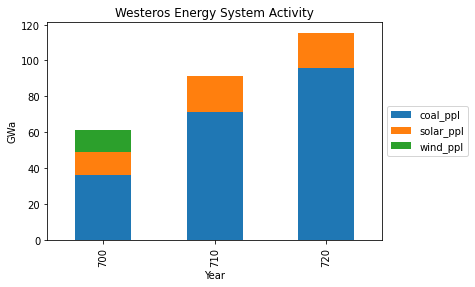

In [11]:
rep.set_filters(t=["coal_ppl", "wind_ppl", "solar_ppl"])
rep.get("plot activity")

### Capacity

How much capacity of each plant is installed in each period?

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

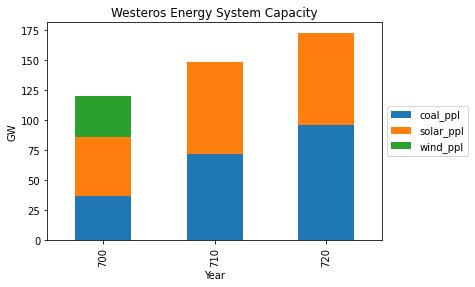

In [12]:
rep.get("plot capacity")

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution. They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of electricity), which is in fact the marginal cost of the most expensive generator.  

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

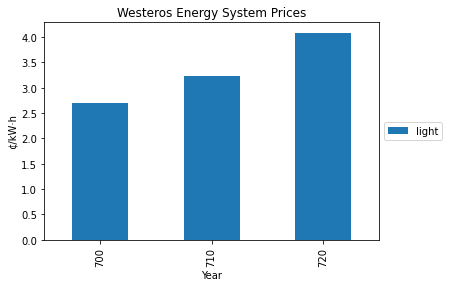

In [13]:
rep.set_filters(t=None, c=["light"])
rep.get("plot prices")

## Close the connection to the database

In [14]:
mp.close_db()

**ANALYSIS**

Now as the emission bound is limited to 500 MtCO2, more installations of solar power plants are being made. In 720 almost 50% of the energy capacity is from solar power. No wind power is part of the system here, the investment costs make is expensive to install, so solar power becomes the more attractive alternative, even though wind has higher capacity factor. The electricity costs have gone up as well compared to when emission bounds were at 800 MtCO2, due to the higher investment costs for solar power plants compared to coal power plants.

Looking at the model, I am surprised that wind power is not included in the later years. I would expect that the energy mix would actally be a mix, including all three types of sources, but the costs for wind power are just too high compared to the other sources.